# Regression Tasks

This notebook addresses the regression tasks for predicting Customer Lifetime Value (CLV_Continuous) using the FinTech dataset. We will build upon the preprocessing from Assignment 01 and apply various regression techniques.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import learning_curve

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Task 1: Data Preprocessing

Start to clean and preprocess the dataset to ensure it is ready for analysis. 

- Use your knowledge of data preprocessing to thoroughly clean and prepare the dataset for 
training. 
- Note: You can reuse or build upon the data cleaning steps from the classification 
assignment. A single, well-documented preprocessing script or notebook is encouraged.

We reuse and build upon the data cleaning steps from the classification assignment. The preprocessing includes:
- Loading the data
- Handling missing values
- Fixing range violations and logical inconsistencies
- Feature engineering and encoding
- Train-test split

We are not going to do a full presentation of the target variables and features. Check assignment 1 for this. 

In [2]:
# Load the dataset
FinTech = pd.read_csv("../Hausarbeit/dataset.csv")
print(f"Dataset shape: {FinTech.shape}")
FinTech.head()

Dataset shape: (8662, 22)


,Customer_ID,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,...,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
0,CUST_000001,553.295220,France,Male,39,2,131008.168572,1,1,0,...,36.942433,8,4.959478,1.094710,1,7.979899,8,0,0,21696.256022
1,CUST_000002,552.939394,France,Male,33,4,118529.788812,1,0,0,...,23.748871,11,9.866506,14.809607,0,11.565167,11,0,0,15918.891128
2,CUST_000003,688.745934,Spain,Male,40,1,-879.724555,2,1,1,...,1.114543,13,6.178311,26.434273,0,3.331838,2,0,0,10361.315773
3,CUST_000004,771.940664,France,Male,40,9,125563.132706,1,1,0,...,1.662811,12,4.509500,18.540471,2,12.714742,1,1,0,15189.776245
4,CUST_000005,484.092560,France,Male,55,5,95759.918567,1,0,1,...,24.007725,8,18.786985,11.893918,1,0.719512,2,0,0,14631.814966


Recap of the distribution of the second (continuous) target variable `CLV_Continuous` which is relevant for this task:

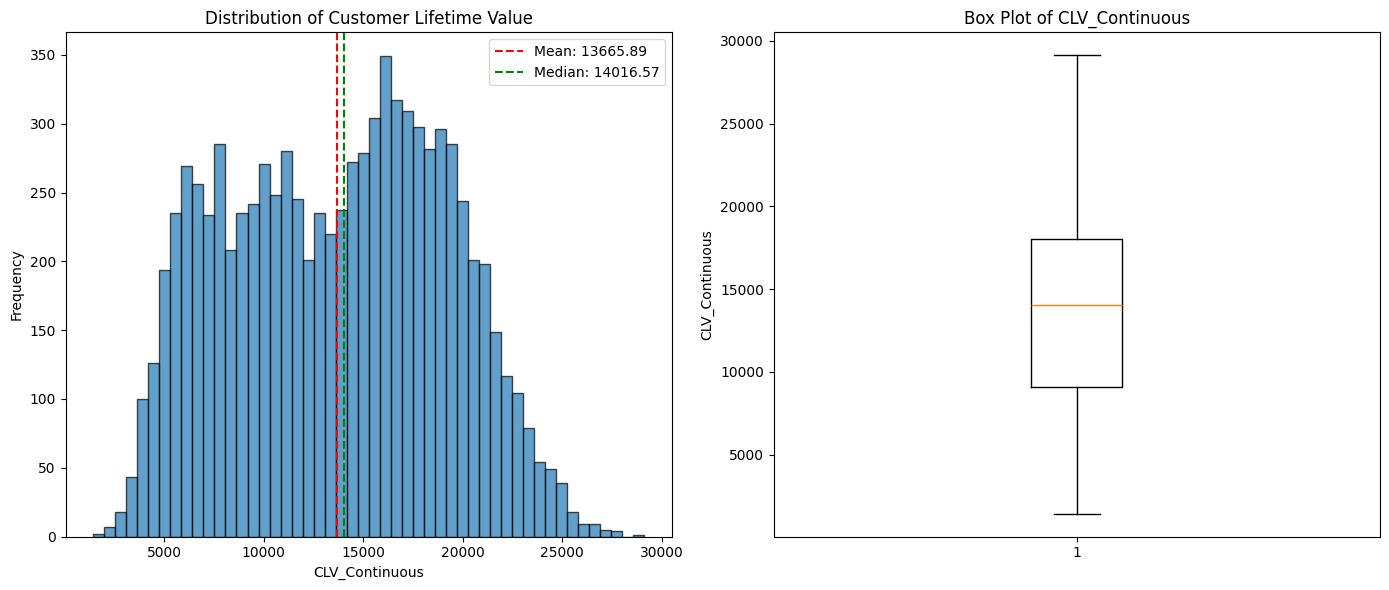

Target variable statistics:
count     8662.000000
mean     13665.885510
std       5443.761692
min       1428.027822
25%       9062.956356
50%      14016.567785
75%      18003.114096
max      29123.502825
Name: CLV_Continuous, dtype: float64


In [3]:
# Analyze the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(FinTech["CLV_Continuous"], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('CLV_Continuous')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Customer Lifetime Value')
axes[0].axvline(FinTech["CLV_Continuous"].mean(), color='red', linestyle='--', label=f'Mean: {FinTech["CLV_Continuous"].mean():.2f}')
axes[0].axvline(FinTech["CLV_Continuous"].median(), color='green', linestyle='--', label=f'Median: {FinTech["CLV_Continuous"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(FinTech["CLV_Continuous"], vert=True)
axes[1].set_ylabel('CLV_Continuous')
axes[1].set_title('Box Plot of CLV_Continuous')

plt.tight_layout()
plt.show()

print(f"Target variable statistics:")
print(FinTech["CLV_Continuous"].describe())

The mean ($13,666) and median ($14.017) are very close, indicating a roughly symmetric distribution with minimal skewness to the right. Looking at the histogram above we can see a single peak at around $14.000 to $15.000. 

Values range from ~$1.400 to ~$29.100, with no extreme outliers. The interquartile range (IQR) spans from ~$9.063 (25th percentile) to ~$18.003 (75th percentile), showing that 50% of customers have CLV values within approximately $9.000 of each other. 

Unlike the imbalanced `Churn` variable, `CLV_Continuous` has a near-normal distribution, making it well-suited for regression models without requiring transformations like log-scaling.

Since we are working with the same dataset as in Assingment 1 we are not going to repeat the exploratory data analysis. Please check the solution for Assignment 1 for this.
We are now going to repeat the cleaning steps we applied for the classification task:

In [4]:
FinTech_cleaned = FinTech.copy()

In [5]:
def clean_obj_cols(df):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].str.strip().str.capitalize()
    return df

FinTech_cleaned = clean_obj_cols(FinTech_cleaned)

In [6]:
geography_mapping = {
    "Fr": "France",
    "De": "Germany",
    "Es": "Spain"
}
FinTech_cleaned["CGeography"] = FinTech_cleaned["CGeography"].replace(geography_mapping)
print(f"CGeography unique values after cleaning: {FinTech_cleaned["CGeography"].unique()}")

CGeography unique values after cleaning: ['France' 'Spain' 'Germany']


In [7]:
def drop_duplicates(df):
    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    print(f"Dropped {initial_shape[0] - final_shape[0]} duplicate rows.")
    return df
FinTech_cleaned = drop_duplicates(FinTech_cleaned)

Dropped 0 duplicate rows.


In [8]:
valid_ranges = {
    "CCreditScore": (0, None), 
    "CAge": (0, 125), ## max age is set way above average life expectancy
    'CTenure': (0, None),               
    "CNumOfProducts": (1, 4),    # As specified: 1 to 4 products        
    "CHasCrCard": (0, 1),      # Binary indicator
    'CIsActiveMember': (0, 1),   # Binary indicator
    "CEstimatedSalary": (0, None), # Salary must be non-negative
    "Days_Since_Onboarding": (0, None), # Days since onboarding must be non-negative
    "Account_Age_Months": (0, None), # Account age in months must be non-negative
    "Avg_Monthly_Transactions": (0, None), # Average monthly transactions must be non-negative
    "Transaction_Variance": (0, None), # Transaction variance must be non-negative
    "Last_Login_Days_Ago": (0, None), # Days since last login must be non-negative
    "Support_Tickets_Count": (0, None), # Support tickets count must be non-negative
    "Mobile_App_Usage_Hours": (0, None), # Mobile app usage hours per week must be non-negative
    "Onboarding_Month": (1, 12), # Onboarding months must be non-negative
    "Is_Holiday_Onboarding": (0, 1), # Binary indicator
    "Churn": (0, 1),           # Binary target variable
    "CLV_Continuous": (0, None)  # Customer Lifetime Value must be non-negative
}

def check_value_ranges(df, ranges):
    violations = {}
    for col, (min_val, max_val) in ranges.items():
        if col in df.columns:
            # Handle one-sided bounds
            if min_val is not None and max_val is not None:
                invalid_mask = (df[col] < min_val) | (df[col] > max_val)
            elif min_val is not None:
                invalid_mask = df[col] < min_val
            elif max_val is not None:
                invalid_mask = df[col] > max_val
            else:
                continue  # Skip if no bounds specified
                
            invalid_count = invalid_mask.sum()
            if invalid_count > 0:
                violations[col] = {
                    'invalid_count': invalid_count,
                    'invalid_values': df.loc[invalid_mask, col].value_counts().to_dict(),
                    'min_found': df[col].min(),
                    'max_found': df[col].max(),
                    'expected_range': f"({'>' if min_val is not None else ''}{min_val if min_val is not None else ''}, {'<' if max_val is not None else ''}{max_val if max_val is not None else ''})"
                }
    return violations

# Check for violations
violations = check_value_ranges(FinTech_cleaned, valid_ranges)

# Display results
if violations:
    print("Found violations in the following columns:")
    for col, details in violations.items():
        print(f"\n{col}:")
        print(f"Expected range: {details["expected_range"]}")
        print(f"Actual range: ({details["min_found"]}, {details["max_found"]})")
        print(f"Number of invalid values: {details["invalid_count"]}")
        print("Invalid values distribution:")
        for val, count in details["invalid_values"].items():
            print(f"  {val}: {count} occurrences")
else:
    print("No violations found. All values are within expected ranges.")

Found violations in the following columns:

CAge:
Expected range: (>0, <125)
Actual range: (-1, 999)
Number of invalid values: 11
Invalid values distribution:
  150: 5 occurrences
  999: 4 occurrences
  -1: 2 occurrences

CEstimatedSalary:
Expected range: (>0, )
Actual range: (-3666.109072, 204659.48037668265)
Number of invalid values: 26
Invalid values distribution:
  -1396.394211: 1 occurrences
  -1429.723173: 1 occurrences
  -1911.331355: 1 occurrences
  -1751.124246: 1 occurrences
  -1170.710205: 1 occurrences
  -1644.086094: 1 occurrences
  -951.1349793: 1 occurrences
  -168.0213447: 1 occurrences
  -261.6387696: 1 occurrences
  -1226.987877: 1 occurrences
  -1302.462259: 1 occurrences
  -1484.919392: 1 occurrences
  -107.6211176: 1 occurrences
  -3666.109072: 1 occurrences
  -1271.130332: 1 occurrences
  -857.6165475: 1 occurrences
  -1362.378234: 1 occurrences
  -974.8646554: 1 occurrences
  -797.7207764: 1 occurrences
  -386.0949363: 1 occurrences
  -253.4656953: 1 occurrences


In [9]:
def handle_range_violations(df, column, min_val, max_val, strategy='impute'):
    """Handle range violations for a single column in the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe (will be copied before changes).
    column : str
        Column name to check and fix.
    min_val, max_val : numeric or None
        Bounds for the valid range. Use None for one-sided bounds.
    strategy : {'impute','clip','remove'}
        How to handle invalid values:
        - 'impute': replace invalid entries with the median of valid values
        - 'clip': clip values to the nearest boundary
        - 'remove': drop rows with invalid values
    """
    df = df.copy()
    if column not in df.columns:
        print(f"Column {column} not found in dataframe. Skipping.")
        return df

    # Build invalid mask depending on which bounds are provided
    if min_val is not None and max_val is not None:
        invalid_mask = (df[column] < min_val) | (df[column] > max_val)
    elif min_val is not None:
        invalid_mask = df[column] < min_val
    elif max_val is not None:
        invalid_mask = df[column] > max_val
    else:
        # No bounds specified; nothing to do
        return df

    n_invalid = int(invalid_mask.sum())
    if n_invalid == 0:
        print(f"No violations found in column '{column}'.")
        return df

    print(f"Found {n_invalid} invalid values in '{column}'. Applying strategy '{strategy}'.")

    if strategy == 'remove':
        # Drop rows with invalid values
        df = df.loc[~invalid_mask].reset_index(drop=True)
    elif strategy == 'clip':
        lower = -np.inf if min_val is None else min_val
        upper = np.inf if max_val is None else max_val
        df.loc[invalid_mask, column] = df.loc[invalid_mask, column].clip(lower=lower, upper=upper)
    elif strategy == 'impute':
        # Compute median from valid (in-range) non-null values
        valid_mask = (~invalid_mask) & df[column].notna()
        if valid_mask.sum() > 0:
            replacement = df.loc[valid_mask, column].median(skipna=True)
        else:
            # Fallback to overall median (may be NaN)
            replacement = df[column].median(skipna=True)
        if pd.isna(replacement):
            print(f"Warning: median for '{column}' is NaN. Leaving values unchanged.")
        else:
            df.loc[invalid_mask, column] = replacement
    else:
        raise ValueError("strategy must be one of 'impute', 'clip', or 'remove'")

    print(f"Applied '{strategy}' to {n_invalid} rows in column '{column}'.")
    return df


In [10]:
for column, (min_val, max_val) in valid_ranges.items():
    if column in violations:
        strategy = "impute"
        FinTech_cleaned = handle_range_violations(
            FinTech_cleaned, column, min_val, max_val, strategy
        )

Found 11 invalid values in 'CAge'. Applying strategy 'impute'.
Applied 'impute' to 11 rows in column 'CAge'.
Found 26 invalid values in 'CEstimatedSalary'. Applying strategy 'impute'.
Applied 'impute' to 26 rows in column 'CEstimatedSalary'.


Check for inconsistent relationships between variables:

In [11]:
days_per_month = 30.44

In [12]:
def fix_age_tenure_constraint(df):
    df = df.copy()
    violations = df[df['CAge'] < df['CTenure']].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'CTenure'] = min(df.loc[idx, 'CTenure'], df.loc[idx, 'CAge'])
        print(f"Constraint 1: {violations_count} entries corrected (CAge >= CTenure)")
    else:
        print("Constraint 1: No violations  (CAge >= CTenure)")
    
    return df

In [13]:
def fix_onboarding_account_age_constraint(df, days_per_month, tolerance_months=1):
    df = df.copy()
    
    expected_months_since_onboarding = df['Days_Since_Onboarding'] / days_per_month
    discrepancy = abs(df['Account_Age_Months'] - expected_months_since_onboarding)
    
    violations = df[discrepancy > tolerance_months].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'Days_Since_Onboarding'] = df.loc[idx, 'Account_Age_Months'] * days_per_month
        print(f"Constraint 2: {violations_count} entries corrected (Onboarding ≈ Account_Age)")
    else:
        print("Constraint 2: No violations (Onboarding ≈ Account_Age)")
    
    return df

In [14]:
def fix_temporal_consistency_constraint(df, days_per_month):
    df = df.copy()
    
    account_age_days = df['Account_Age_Months'] * days_per_month
    violations = df[df['Last_Login_Days_Ago'] > account_age_days].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            account_age_in_days = df.loc[idx, 'Account_Age_Months'] * days_per_month
            df.loc[idx, 'Last_Login_Days_Ago'] = max(1, account_age_in_days - 1)
        print(f"Constraint 3: {violations_count} entries corrected (Last_Login <= Account_Age)")
    else:
        print("Constraint 3: No violations (Last_Login <= Account_Age)")
    
    return df

In [15]:
FinTech_cleaned =fix_age_tenure_constraint(FinTech_cleaned)
FinTech_cleaned =fix_onboarding_account_age_constraint(FinTech_cleaned, days_per_month)
FinTech_cleaned =fix_temporal_consistency_constraint(FinTech_cleaned, days_per_month)

Constraint 1: No violations  (CAge >= CTenure)
Constraint 2: 40 entries corrected (Onboarding ≈ Account_Age)
Constraint 3: 322 entries corrected (Last_Login <= Account_Age)


## Data Splitting

In [16]:
# define features and target
X = FinTech_cleaned.drop(columns=["Churn", "CLV_Continuous", "Customer_ID"])
y = FinTech_cleaned["CLV_Continuous"]

from sklearn.model_selection import train_test_split
#split data 
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Stratification is not needed in this case because y is not a binary variable but continuous.

## Check for missing values and outliers

We are going to skip the check for missing values and outliers. Please check the solution for assignment 1 for this.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=3):
        self.multiplier = multiplier
        self.bounds_ = {}
        self.n_features_in_ = None
        self.feature_names_in_ = None
    
    def fit(self, X, y=None):
        X = np.array(X)
        for i in range(X.shape[1]):
            mean = np.nanmean(X[:, i])
            std = np.nanstd(X[:, i])
            self.bounds_[i] = (mean - self.multiplier * std, 
                               mean + self.multiplier * std)
        return self
    
    def transform(self, X):
        X = np.array(X).copy()
        for i in range(X.shape[1]):
            lower, upper = self.bounds_[i]
            X[:, i] = np.clip(X[:, i], lower, upper)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Return feature names (passthrough since we don't change columns)."""
        if input_features is None:
            return np.array([f'x{i}' for i in range(self.n_features_in_)])
        return np.array(input_features)

## Pre-Processing Pipeline

As for the Classification Task we are going to use a pipeline that includes the following pre-processing steps:
- Handling Missing Values (Imputation)
- Handling Outliers (Winsorization)
- Feature Engineering (One-Hot-Encoding)
- Data Transformation

Linear, Polynomial, Ridge- and Lasso-Regression as well as Elastic net have the following properties and assumptions (slide 95 from lecture 3):

|  | **Linear Regression** | **Polynomial Regression** | **Ridge Regression, Lasso Regression and Elastic Net** |
|------------|----------------------|---------------------------|--------------------------------------------------------|
| **Target function** | • linear relationship<br>(straight line) | • quadratic relation<br>• Polynomial of higher degree | • linear relationship<br>• quadratic relation<br>• Polynomial of higher degree |
| **Hyperparameters and methods** | • no Hyperparameters in linear regression with normal equation<br>• ≥ 2 Hyperparameters with Stochastic Gradient Descent | • no Hyperparameters in linear regression with normal equation<br>• ≥ 2 Hyperparameters with Stochastic Gradient Descent | • 1 hyperparameter plus mixing ratio for Elastic Net<br>• Stochastic gradient method with ridge regression (ℓ2) or lasso regression (ℓ1) |
| **Scaling and Centering** | • not required | • not required | • Required for quadratic polynomial and polynomials of higher degree |

Furthermore a linear regression has the following assumptions regarding the dataset:
1. Linearity: Linear relationship between the independent (features) and dependent variables (label). Fitting the linear model to non-linear data could cause underfitting.
2. Independance: Residuals must not correlate with each other across observations.
3. Homoscedasticity: For every level of the independent variables, the variance of the errors should remain constant.
4. Normality: A normal distribution should be present in the errors (residuals).
5. Lack of multicollinearity: There should be little to no significant correlation between the independent variables. 

In order to satisfy the linear regression assumptions we are applying a transformation (yeo-johnson transformation) with the PowerTransformer in the pipeline.

Because the quadratic polynomial and higher degree polynomials for the Ridge or Lasso Regression require scaled and centered data (see table above) data scaling with RobustScaler is also applied to standardize the data.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer

Create separate pipelines for numerical and categorical variables:

In [19]:
cat_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

Feature Engineering: Encoding variables
We are going to use one-hot encoding for categorical variables, which are defined as follows:

In [20]:
cat_cols = ["CGeography", "CGender", "CHasCrCard" ,"CIsActiveMember", "Is_Holiday_Onboarding", "Onboarding_Month"]

Since the percentage of missingness is small (<10%) we are using imputation techniques to fill the missing values.
Due to the small percentage of missing values and the fact that there does not seem to be a systematic pattern of missingness the impact on data quality is limited, but still present.
Using the imputation with the median we account for the skewness of the distribution of both variables with missing values by preserving their distributions central tendency.

In [21]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier', OutlierWinsorizer(multiplier=3)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])


We use RobustScaler and not StandardScaler because there are plenty of outliers in the dataset and still could be after winsorization.

Because some distributions of variables have a skewed distribution we are applying PowerTransformer at the end of the pipeline to ensure normality. PowerTransformer uses Yeo-Johnson (extension of Box-cox transformation) to automatically find the optimal transformation per feature to achieve a gaussian-like distribution.

Collect all numerical columns thar should be considered for num_transformer:

In [22]:
all_numeric_cols = [col for col in X_train.columns if col not in 
                  ["Customer_ID","Churn"] + cat_cols]

Master pipeline:

In [23]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, all_numeric_cols),
    ('cat', cat_transformer, cat_cols)
],
remainder='passthrough'
)

Next we fit the pipeline on training dataset and transform both training and test set. The pipeline avoids data leakage. For example when winsorizing the thresholds are determined solely from the training data (as we did before when checking for outliers) and applied to both training and test data.

In [24]:
X_train_processed = preprocessor.fit_transform(X_train)
feature_names_train = preprocessor.get_feature_names_out()

# ensure that the test data is transformed in the same way

X_test_processed = preprocessor.transform(X_test)
feature_names_test = preprocessor.get_feature_names_out()

# convert np-array to dataframe

X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_train)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_test)

Distribution of the variables in X_train after preprocessing pipeline:

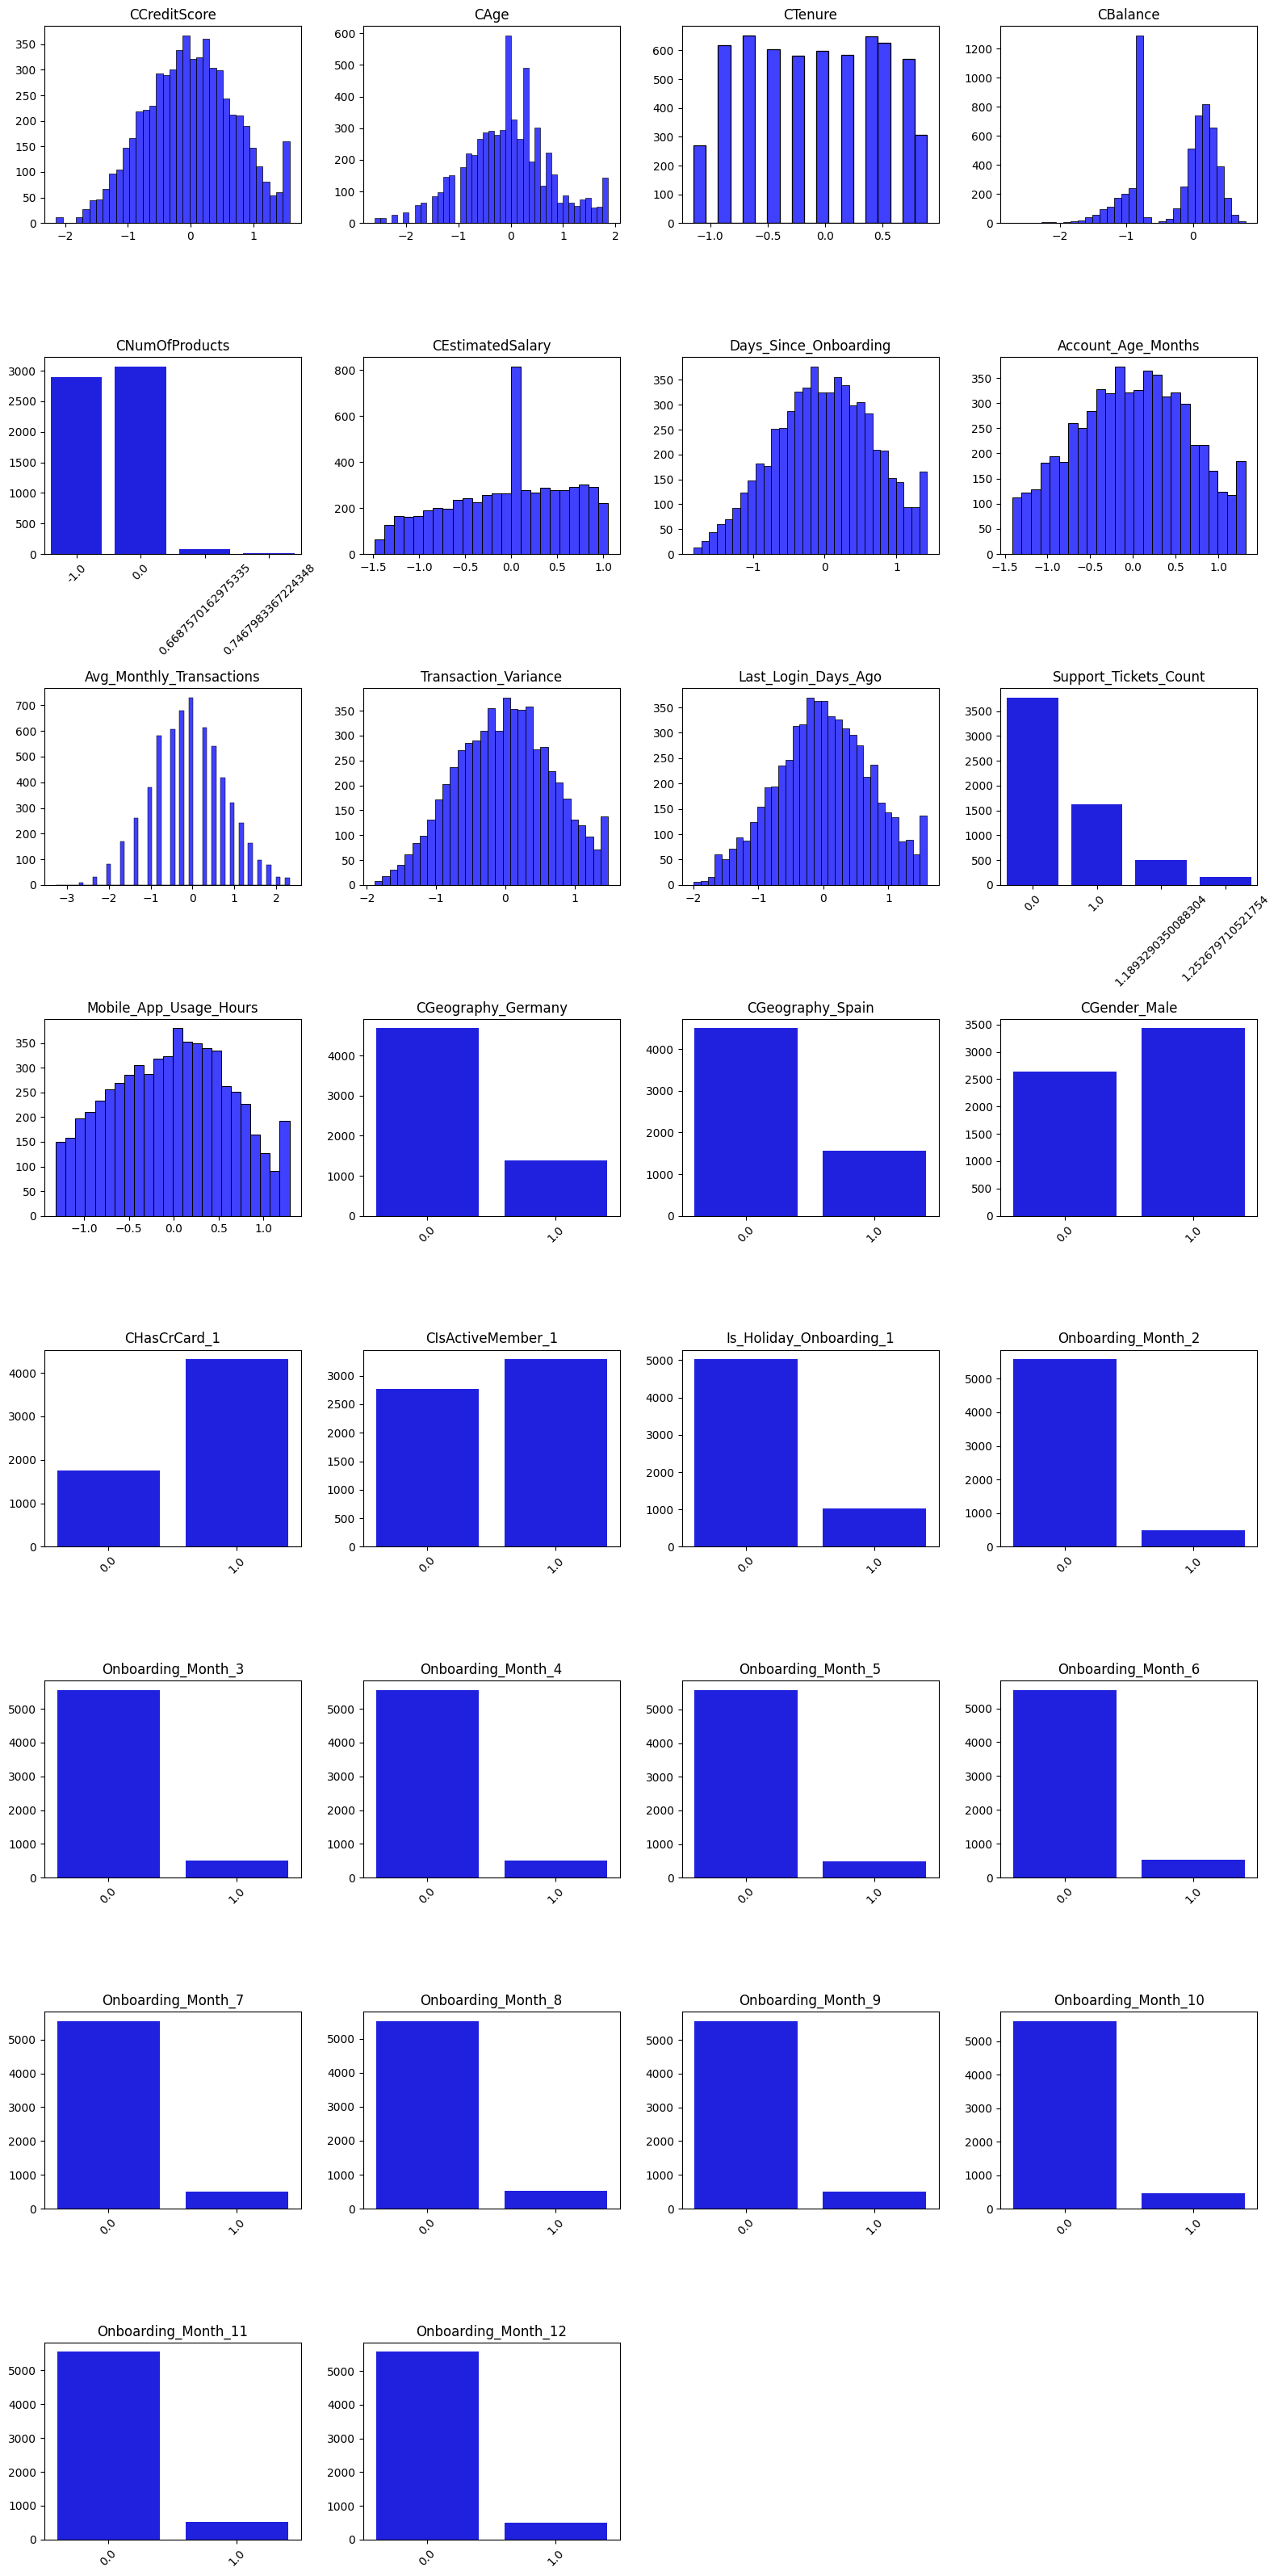

In [25]:
cols = X_train_processed_df.columns.tolist()
n_cols = 4
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    # Use countplot for categorical (one-hot encoded) or binary columns
    if X_train_processed_df[col].nunique() <= 5:
        sns.countplot(x=X_train_processed_df[col], ax=axes[i], color='blue')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        sns.histplot(x=X_train_processed_df[col], ax=axes[i], color='blue')
    
    # Clean up column name for title (remove prefixes like num__, cat__, etc.)
    clean_name = col.replace('num__', '').replace('cat__', '').replace('bin__', '')
    axes[i].set_title(clean_name)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove empty axes if necessary
for ax in axes[len(cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


We can see that most of the skewness and outliers were tackled during scaling and data transformation. We have to keep the transformation using PowerTransformer in mind. If we want to interpret coefficients or feature importance or communicate our findings to stakeholders at a later stage the data has to be transformed back. 

In order for the dataset to be "model-ready" we are going to create a subset that contains the features of the models for the regression task.

In [26]:
model_features = [col for col in X_train_processed_df.columns if col not in 
                  ["remainder__Customer_ID", "remainder__Churn"]]

## Check for Multicollinearity

We have to check for multicollinearity  and remove highly correlated features or apply dimensionality techniques to take this into account. To do this we are taking a look at a correlation matrix:

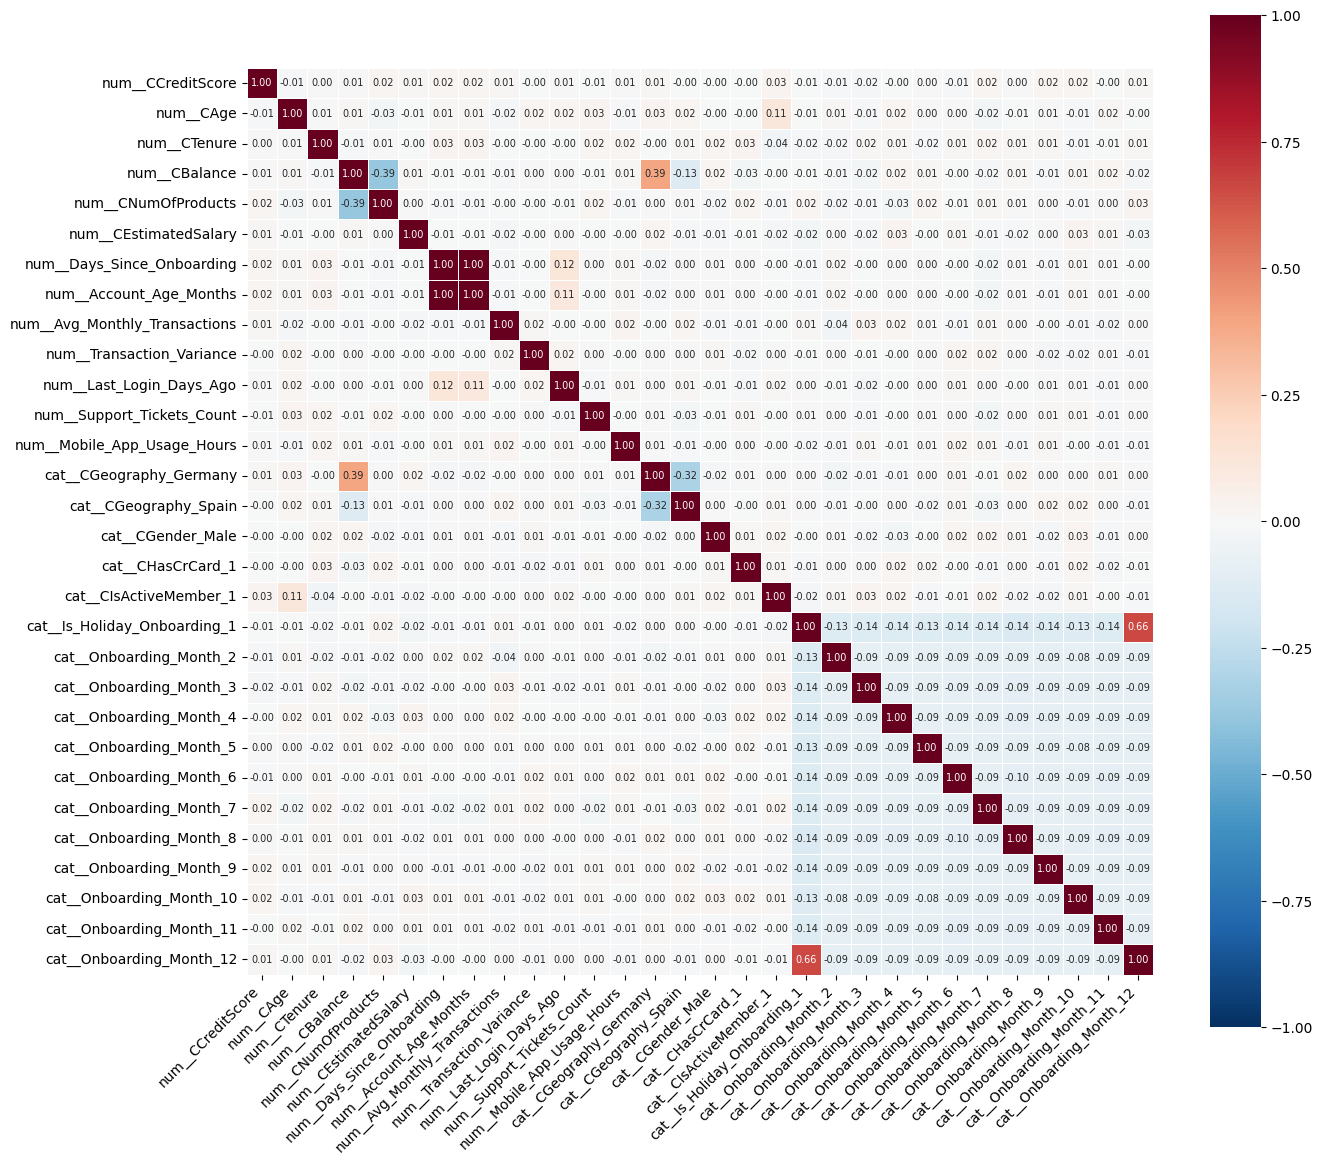

In [27]:
correlation_matrix = X_train_processed_df[model_features].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',              # 2 decimal places instead of many
    cmap='RdBu_r',          # Diverging colormap
    center=0,               # Center at 0
    vmin=-1, vmax=1,        # Fixed scale
    square=True,            # Square cells
    linewidths=0.5,         # Grid lines between cells
    annot_kws={'size': 7}   # Smaller font for annotations
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Also we can see a perfect positive correlation between `Days_Since_Onboarding` and `Account_Age_Months`. We are going to drop `Days_Since_Onboarding` as recommended in the task description.

In [28]:
model_features.remove('num__Days_Since_Onboarding')
X_train_processed_df = X_train_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_test_processed_df = X_test_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_train_processed = X_train_processed_df.values
X_test_processed = X_test_processed_df.values

We are going to double check now by calculating the Variance Inflation Factor (VIF) to check if there really is no significant correlation between the independant variables (features):

In [29]:
correlation_matrix = X_train_processed_df[model_features].corr()

# Identify pairs of features with high collinearity (correlation > 0.8 or < -0.8)
high_corr_features = [(col1, col2, correlation_matrix.loc[col1, col2])
                     for col1 in correlation_matrix.columns
                     for col2 in correlation_matrix.columns
                     if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

In [30]:
# Convert to a DataFrame for better visualization.
collinearity_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])
print("\nHighly Correlated Features:\n", collinearity_df)

# Compute Variance Inflation Factor (VIF) for each feature.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed_df[model_features].columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_df[model_features].values, i) for i in range(X_train_processed_df[model_features].shape[1])]


# Print VIF values.
print("\nVariance Inflation Factor (VIF) for each feature:\n", vif_data)


Highly Correlated Features:
 Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []

Variance Inflation Factor (VIF) for each feature:
                           Feature       VIF
0               num__CCreditScore  1.004548
1                       num__CAge  1.019532
2                    num__CTenure  1.007423
3                   num__CBalance  1.445902
4             num__CNumOfProducts  1.225685
5           num__CEstimatedSalary  1.004616
6         num__Account_Age_Months  1.015612
7   num__Avg_Monthly_Transactions  1.005993
8       num__Transaction_Variance  1.003062
9        num__Last_Login_Days_Ago  1.014997
10     num__Support_Tickets_Count  1.003925
11    num__Mobile_App_Usage_Hours  1.002885
12        cat__CGeography_Germany  1.338864
13          cat__CGeography_Spain  1.120558
14              cat__CGender_Male  1.005477
15              cat__CHasCrCard_1  1.004587
16         cat__CIsActiveMember_1  1.019351
17   cat__Is_Holiday_Onboarding_1  3.390082
18        c

The VIF-Check supports the findings from the visual inspection. Except for the already removed feature, there are no other highly correlated features in the dataset. The VIF of `cat_Is_Holiday_Onboarding` is slightly higher (3.39) indicating a low/moderate correlation. This makes sense because likely correlates with all `cat__Onboarding_Month` features. The correlation matrix above indicates this as well. Because it is an expectable and not significant correlation we can accept it as it is.
The model features are sufficiently independant. Therefore we can proceed with training and evaluating the regression models.

## Task 2: Train and Evaluate a Multiple Regression Model

- Build a multiple linear regression model to predict Customer Lifetime Value (regression using 
the 'CLV_Continuous' target variable)". 
- Describe your approach to building the model and interpret the performance based on 
appropriate evaluation metrics. 

Note: You are not expected to use regularization or hyperparameter tuning at this stage. 

First we are creating a helper function to evaluate the model using the following metrices:
- Coefficient of Determination (R²): The proportion of the variance in the dependant variable (label) that is predictable from the independant variable (feature). Increases with every independant variable added to the model, hence the adjusted R² has to be considered as well. 
- Adjusted R²: Also indicates how well terms fit a curve or line but ajusts for the number of terms in a model. 
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

Also we are going to look at the coefficients or feature importances, depending on the model, and plot the distribution of the residuals and the model fit with this function. The idea is to reuse this function during the following tasks.

In [31]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model",
                   feature_names=None, plot_top_n=15):
    """
    Evaluate regression model and return metrics with visualizations.

    Parameters:
    -----------
    model : estimator object
        Trained model (LinearRegression, Ridge, DecisionTree, ensemble models, etc.)
    X_train, X_test : array-like
        Training and test feature sets
    y_train, y_test : array-like
        Training and test target values
    model_name : str
        Name of the model for display purposes
    feature_names : list, optional
        Names of features for coefficient/importance plots
    plot_top_n : int, default=15
        Number of top features to display in importance plot

    Returns:
    --------
    metrics : dict
        Dictionary containing performance metrics
    y_test_pred : array-like
        Test set predictions
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # values to calculate the adjusted r2
    n_train, p = X_train.shape
    n_test = X_test.shape[0]

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Adjusted R² with validity check
    if n_train - p - 1 <= 0:
        adjusted_train_r2 = np.nan
    else:
        adjusted_train_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p - 1)

    if n_test - p - 1 <= 0:
        adjusted_test_r2 = np.nan
    else:
        adjusted_test_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p - 1)

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Adjusted_Train_R2': adjusted_train_r2,
        'Adjusted_Test_R2': adjusted_test_r2,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }

    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(f"\nTraining Set:")
    print(f"  R-squared: {metrics['Train_R2']:.4f}")
    print(f"  Adjusted R-squared: {metrics['Adjusted_Train_R2']:.4f}")
    print(f"  RMSE: {metrics['Train_RMSE']:.2f}")
    print(f"  MAE: {metrics['Train_MAE']:.2f}")
    print(f"\nTest Set:")
    print(f"  R-squared: {metrics['Test_R2']:.4f}")
    print(f"  Adjusted R-squared: {metrics['Adjusted_Test_R2']:.4f}")
    print(f"  RMSE: {metrics['Test_RMSE']:.2f}")
    print(f"  MAE: {metrics['Test_MAE']:.2f}")

    # ========== VISUALIZATIONS ==========

    # 1. Feature Coefficients/Importance Plot
    if feature_names is not None:
        has_coef = hasattr(model, 'coef_')
        has_feature_importances = hasattr(model, 'feature_importances_')

        if has_coef or has_feature_importances:
            
            if has_coef:
                # Linear models (LinearRegression, Ridge, Lasso)
                coef_values = model.coef_
                
                # Ensure feature_names matches coefficient length
                if len(feature_names) != len(coef_values):
                    print(f"\nWarning: Feature names length ({len(feature_names)}) doesn't match coefficients length ({len(coef_values)})")
                    print(f"Adjusting feature names to match...")
                    if len(feature_names) > len(coef_values):
                        feature_names = list(feature_names[:len(coef_values)])
                    else:
                        feature_names = list(feature_names) + [f"Feature_{i}" for i in range(len(feature_names), len(coef_values))]
                
                # Create full dataframe with all coefficients
                all_importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coef_values
                }).sort_values('Coefficient', ascending=False)
                
                # Print all coefficients
                print(f"\n{'='*60}")
                print(f"All Feature Coefficients (sorted by absolute value):")
                print(f"{'='*60}")
                print(all_importance_df.to_string(index=False))
                
                # Plot top N
                importance_df = all_importance_df.head(plot_top_n)
                
                fig, ax = plt.subplots(figsize=(10, 8))
                colors = ['green' if x > 0 else 'red' for x in importance_df['Coefficient']]
                bars = ax.barh(range(len(importance_df)), importance_df['Coefficient'], color=colors, alpha=0.7)

                # Add coefficient values on bars
                for i, (idx, row) in enumerate(importance_df.iterrows()):
                    value = row['Coefficient']
                    x_pos = value + (0.02 * (importance_df['Coefficient'].max() - importance_df['Coefficient'].min()))
                    ha = 'left' if value > 0 else 'right'
                    x_pos = value + (0.5 if value > 0 else -0.5)
                    ax.text(x_pos, i, f'{value:.2f}', va='center', ha=ha, fontsize=9, fontweight='bold')

                ax.set_yticks(range(len(importance_df)))
                ax.set_yticklabels(importance_df['Feature'])
                ax.set_xlabel('Coefficient Value')
                ax.set_title(f'{model_name}: Top {plot_top_n} Feature Coefficients')
                ax.axvline(0, color='black', linestyle='-', linewidth=0.8)

            elif has_feature_importances:
                # Tree-based models (DecisionTree, RandomForest, GradientBoosting)
                importance_values = model.feature_importances_
                
                # Ensure feature_names matches importance length
                if len(feature_names) != len(importance_values):
                    print(f"\nWarning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(importance_values)})")
                    print(f"Adjusting feature names to match...")
                    if len(feature_names) > len(importance_values):
                        feature_names = list(feature_names[:len(importance_values)])
                    else:
                        feature_names = list(feature_names) + [f"Feature_{i}" for i in range(len(feature_names), len(importance_values))]
                
                # Create full dataframe with all importances
                all_importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importance_values
                }).sort_values('Importance', ascending=False)
                
                # Print all importances
                print(f"\n{'='*60}")
                print(f"All Feature Importances (sorted descending):")
                print(f"{'='*60}")
                print(all_importance_df.to_string(index=False))
                
                # Plot top N
                importance_df = all_importance_df.head(plot_top_n)
                
                fig, ax = plt.subplots(figsize=(10, 8))
                bars = ax.barh(range(len(importance_df)), importance_df['Importance'], color='steelblue', alpha=0.7)

                # Add importance values on bars
                for i, (idx, row) in enumerate(importance_df.iterrows()):
                    value = row['Importance']
                    x_pos = value + (0.01 * importance_df['Importance'].max())
                    ax.text(x_pos, i, f'{value:.4f}', va='center', ha='left', fontsize=9, fontweight='bold')

                ax.set_yticks(range(len(importance_df)))
                ax.set_yticklabels(importance_df['Feature'])
                ax.set_xlabel('Importance')
                ax.set_title(f'{model_name}: Top {plot_top_n} Feature Importances')

            ax.invert_yaxis()
            plt.tight_layout()
            plt.show()

    # 2. Residuals and Regression Fit
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Regression Fit (Actual vs Predicted)
    axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual CLV')
    axes[0].set_ylabel('Predicted CLV')
    axes[0].set_title(f'{model_name}: Predicted vs Actual')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Residuals Distribution
    residuals = y_test - y_test_pred
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    axes[1].set_xlabel('Residuals (Actual - Predicted)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name}: Residual Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return metrics, y_test_pred


Multiple Linear Regression Performance

Training Set:
  R-squared: 0.8983
  Adjusted R-squared: 0.8978
  RMSE: 1730.81
  MAE: 1202.98

Test Set:
  R-squared: 0.9018
  Adjusted R-squared: 0.9007
  RMSE: 1716.94
  MAE: 1184.81

All Feature Coefficients (sorted by absolute value):
                      Feature  Coefficient
                num__CBalance  8075.844533
        num__CEstimatedSalary  3379.566438
       cat__CIsActiveMember_1  1242.904120
          num__CNumOfProducts  1071.599323
      num__Account_Age_Months   861.766066
            cat__CHasCrCard_1   827.423685
      cat__CGeography_Germany   284.394772
      cat__Onboarding_Month_2   108.071401
            cat__CGender_Male    97.425473
     cat__Onboarding_Month_11    78.935743
     cat__Onboarding_Month_12    57.168408
     cat__Onboarding_Month_10    36.709820
      cat__Onboarding_Month_3    26.110809
      cat__Onboarding_Month_6    13.376735
num__Avg_Monthly_Transactions     5.985967
  num__Mobile_App_Usage_Hours   

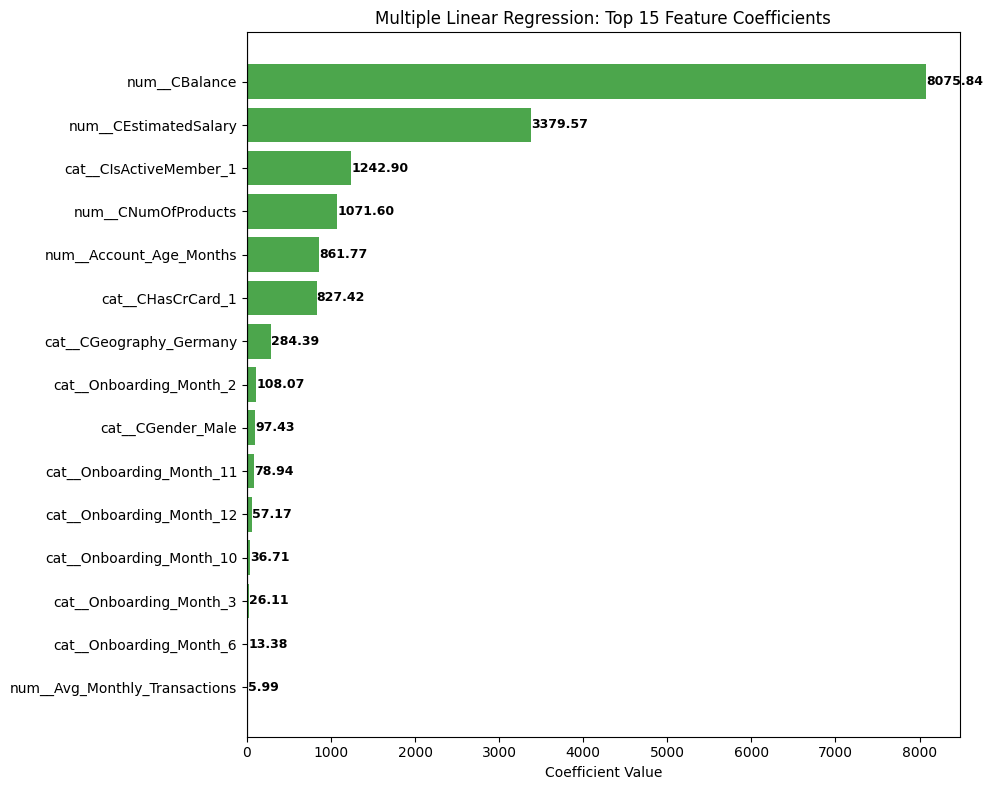

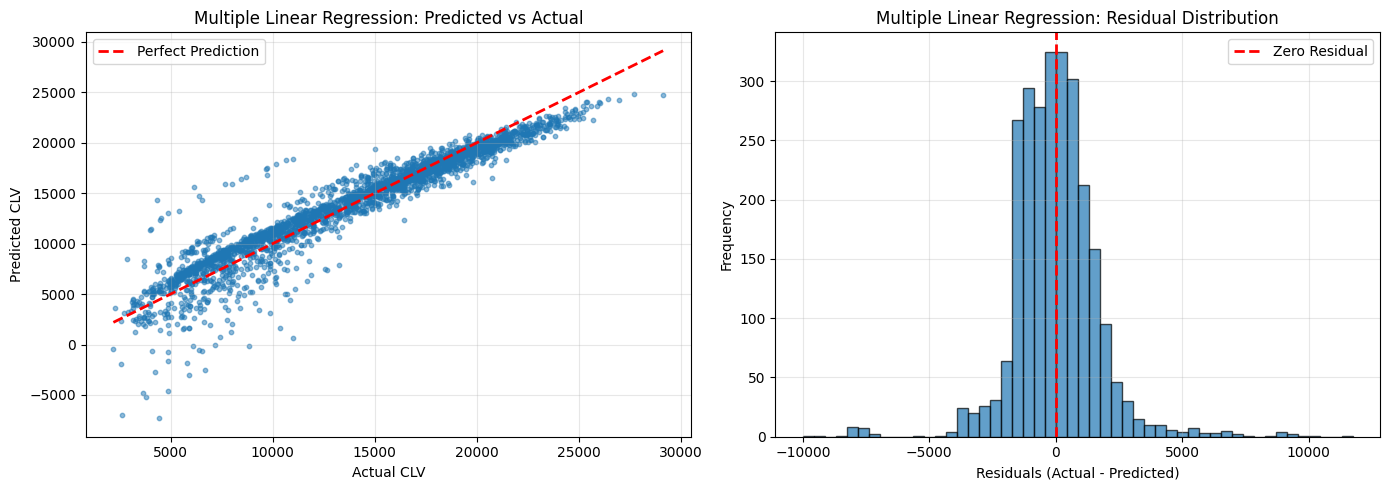

In [32]:
# Train Multiple Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Evaluate the model
lr_metrics, lr_pred = evaluate_model(
    lr_model, 
    X_train_processed, 
    X_test_processed, 
    y_train, 
    y_test, 
    model_name = "Multiple Linear Regression", 
    feature_names = X_train_processed_df.columns
)

### Interpretation of Linear Regression Results

The multiple linear regression model provides a baseline for predicting Customer Lifetime Value. Key observations:

1. **Adjusted R-squared**: Around 0,90 on both training and test set. This means that the model explains around 90 % of the variance in the Customer Lifetime Value. The similar performance on the training and test set indicate no overfitting. All in all this is a good value.
2. **RMSE**: On average the predictions are off by ~ 1.717 $. 
3. **MAE**: The mean error is ~ 1.185 $.

Looking at the **Coefficients** we have the following findings:

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `CBalance` | +8,076 | Strongest predictor. Higher balance → higher target value |
| `CEstimatedSalary` | +3,380 | Higher salary customers have higher target values |
| `CIsActiveMember_1` | +1,243 | Active members have ~1,243 higher target than inactive |
| `CNumOfProducts` | +1,072 | Each additional product → ~1,072 increase |
| `Account_Age_Months` | +862 | Older accounts have higher values |
| `CHasCrCard_1` | +827 | Having a credit card → ~827 higher target |

**Negative Predictors:**

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `CAge` | -135 | Older customers have slightly lower target values |
| `Last_Login_Days_Ago` | -92 | More days since login → lower target (engagement matters) |
| `CTenure` | -35 | Slight negative effect (possibly collinear with Account_Age) |
| `Support_Tickets_Count` | -35 | More support tickets → slightly lower target |

**Negligible Impact:**

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| `Mobile_App_Usage_Hours` | +0.77 | Minimal effect on target |
| `Transaction_Variance` | -5.7 | Minimal effect on target |
| `Onboarding_Month_*` | varies | Small coefficients suggest onboarding timing doesn't matter much |

**Regression Fit and Residuals Distribution**

Based on the regression fit plot we can see that the points generally follow the diagonal line (perfect fit), which confirms our adjusted R² of around 0,90. The model captures the overall trend well. 
But we can see that some values go below zero, which is concerning because the dataset does not include negative CLV. Also we can see that the scatter widens at lower CLV-values, which indicates that the model is less accurate for low-CLV customers. We can see outliers at the lower CLV end. There is a cluster of points at low actual CLV (2000 - 5000) that is being predicted as negative or near-zero.

The residual distribution is centered around zero, which indicates that the errors are randomly distributed (no systematic bias). Also the distribution is roughly bell-shaped, suggesting the distribution of the residuals follows a normal distribution.
There are heavy tails and a slight right skew, which indicates some predicition errors. Furthermore there are small clusters at the extremes (-10.000 and +10.000).

## Task 3: Polynomial Regression Models

- Train and evaluate at least two polynomial regression models with different polynomial 
degrees. 
- Compare the results of the polynomial regression models with the linear regression model 
from Task 2. Discuss how the model's performance changes as the degree of the polynomial 
increases.

Polynomial regression extends linear regression by adding polynomial terms, allowing the model to capture non-linear relationships. (relationships between features) 

We will train models with different polynomial degrees and compare their performance.


Training Polynomial Regression (degree=2)
Features after polynomial transformation: 464

Polynomial Regression (degree=2) Performance

Training Set:
  R-squared: 0.9692
  Adjusted R-squared: 0.9666
  RMSE: 952.98
  MAE: 586.12

Test Set:
  R-squared: 0.9671
  Adjusted R-squared: 0.9599
  RMSE: 994.60
  MAE: 619.85

All Feature Coefficients (sorted by absolute value):
                                                   Feature   Coefficient
                                             num__CBalance  1.071246e+04
                                           num__CBalance^2  4.317463e+03
                                     num__CEstimatedSalary  3.312465e+03
                     num__CBalance cat__Onboarding_Month_8  1.166720e+03
                     num__CBalance cat__Onboarding_Month_2  1.153506e+03
                     num__CBalance cat__Onboarding_Month_4  1.094082e+03
                    num__CBalance cat__Onboarding_Month_11  1.080844e+03
                                       num__C

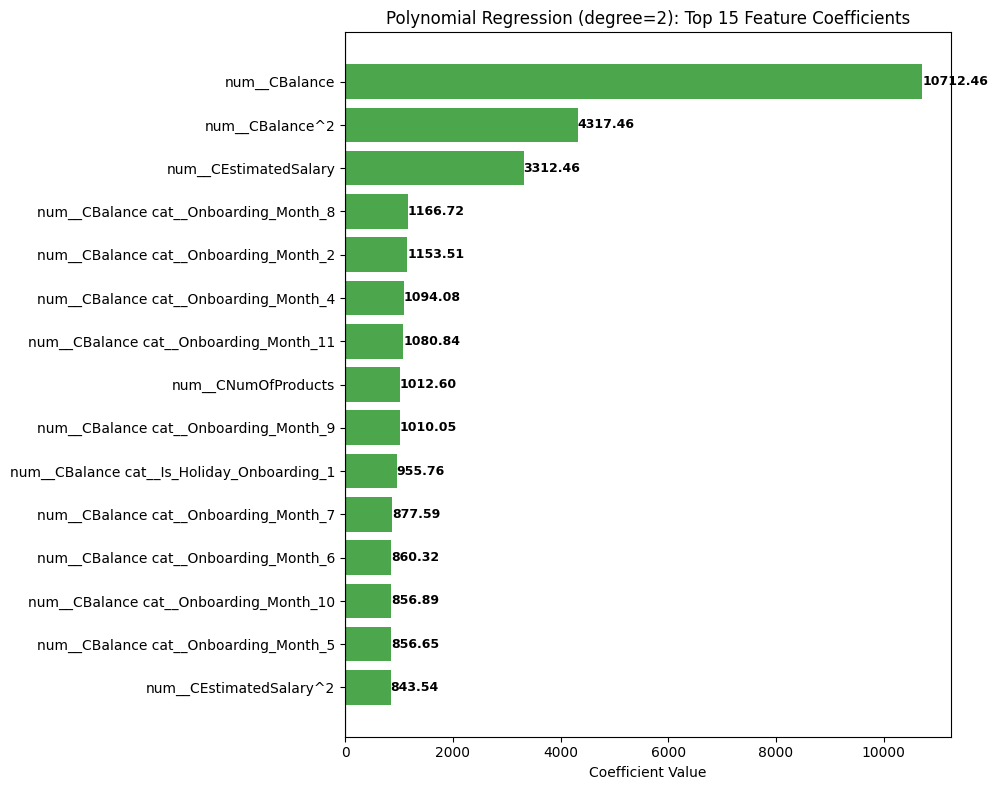

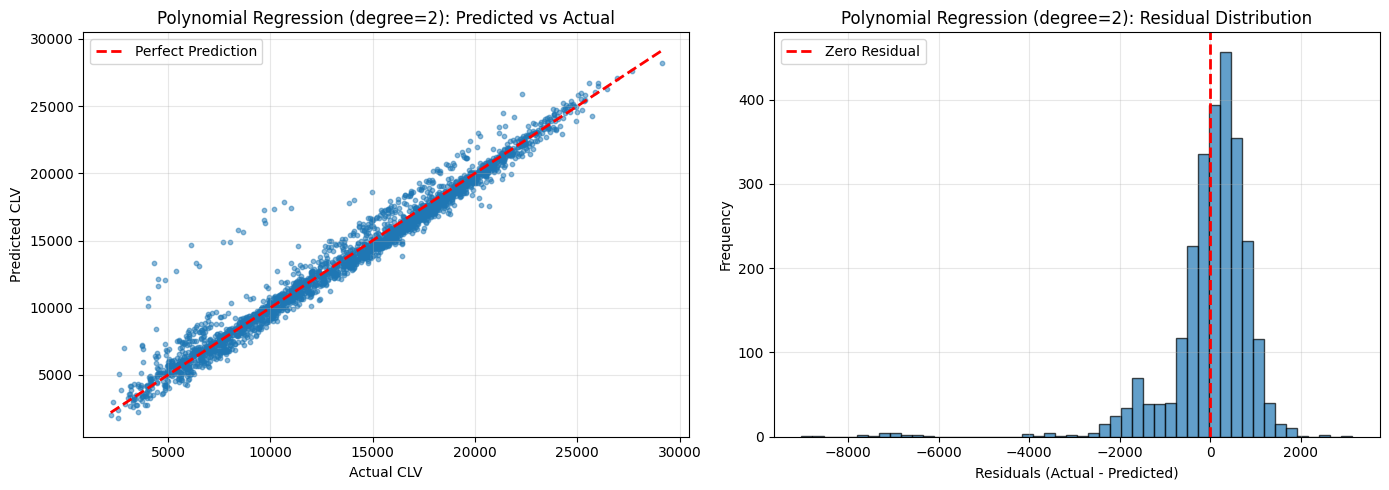


Training Polynomial Regression (degree=3)
Features after polynomial transformation: 4959

Polynomial Regression (degree=3) Performance

Training Set:
  R-squared: 0.9841
  Adjusted R-squared: 0.9125
  RMSE: 684.75
  MAE: 486.30

Test Set:
  R-squared: 0.9394
  Adjusted R-squared: nan
  RMSE: 1349.52
  MAE: 951.91

All Feature Coefficients (sorted by absolute value):
                                                                               Feature   Coefficient
                                                                 num__CNumOfProducts^3  1.657002e+04
                                                                         num__CBalance  1.035713e+04
                                                                 num__CNumOfProducts^2  5.068790e+03
                                                                       num__CBalance^2  4.786488e+03
                                                            num__Support_Tickets_Count  4.492464e+03
                        

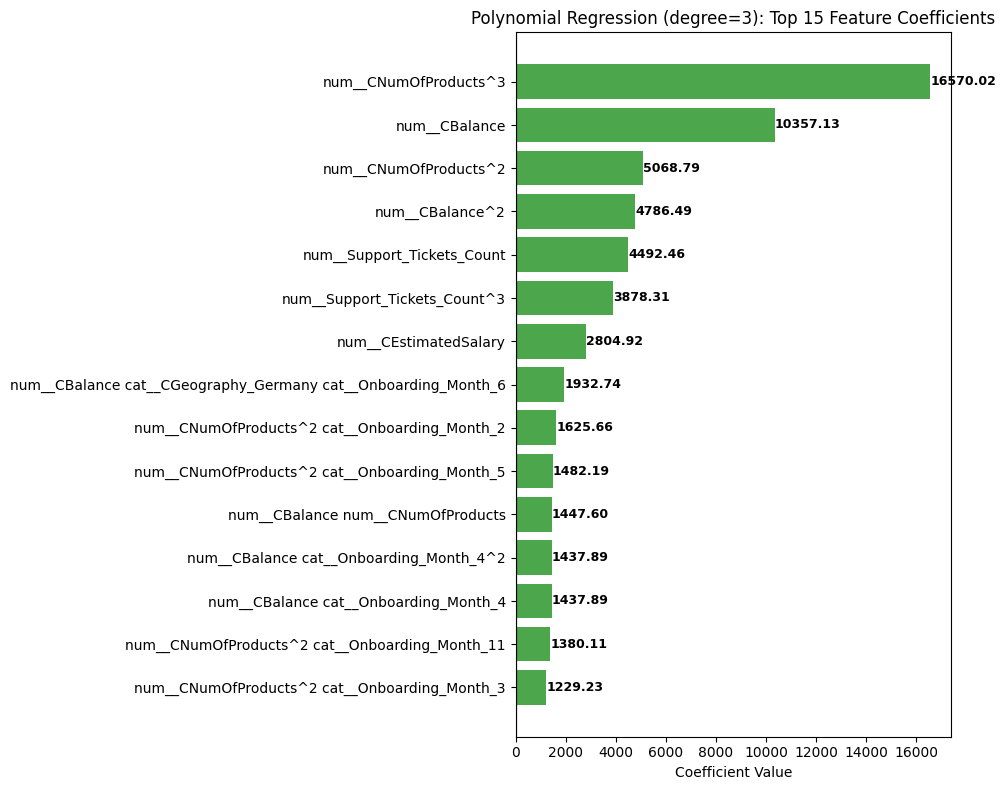

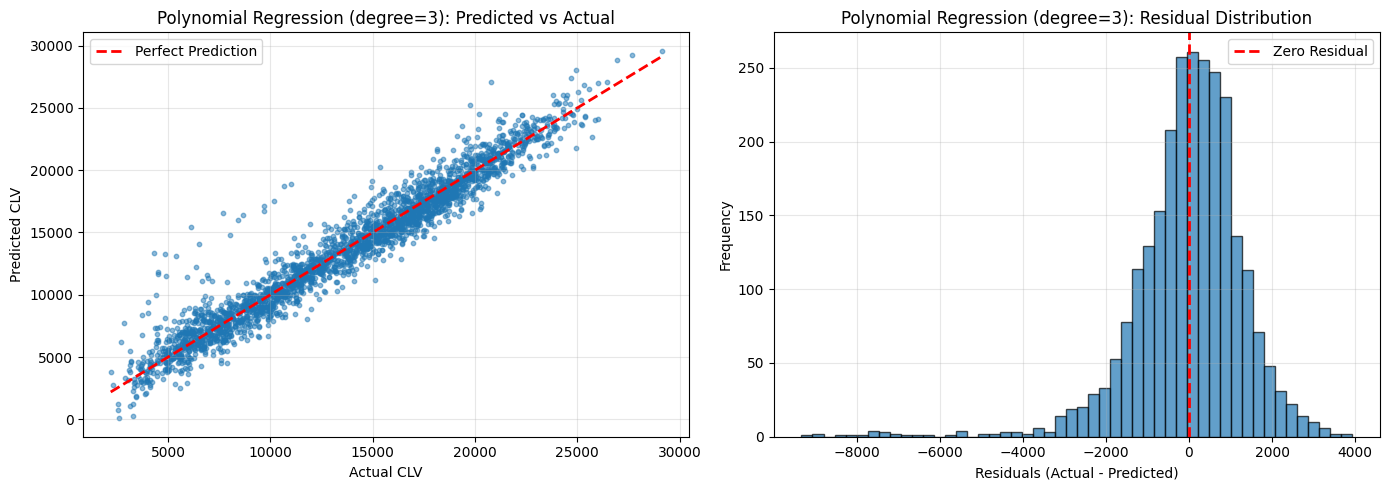

In [33]:
# Train polynomial regression models with different degrees
poly_results = []

for degree in [2, 3]:
    print(f"\n{'='*60}")
    print(f"Training Polynomial Regression (degree={degree})")
    print(f"{'='*60}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_processed)
    X_test_poly = poly.transform(X_test_processed)
    
    print(f"Features after polynomial transformation: {X_train_poly.shape[1]}")
    
    # Train model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Evaluate
    metrics, pred = evaluate_model(
        poly_model, 
        X_train_poly, 
        X_test_poly,
        y_train, 
        y_test, 
        model_name = f"Polynomial Regression (degree={degree})",
        feature_names = poly.get_feature_names_out(X_train_processed_df.columns)

    )
    
    poly_results.append({
        'degree': degree,
        'model': poly_model,
        'poly_transformer': poly,
        'metrics': metrics,
        'predictions': pred
    })

We can not calculate the adjusted R² for the polynomial regression with degree 3 because the number of features (p) is greater than the number of test samples (n_test). 

Since no regularization or hyperparameter tuning is required at this stage, we are not going to create learning curves.

### Interpretation of Polynomial Regression Results

As said before in contrast to linear regression the polynomial regression models are capable of finding realtionships between features. 
Higher-degree polynomials create more complex models that can memorize training data but often fail to generalize to new data. With the high degree polynomial regression the training data will likely fit much better than with the linear regression.
All in all there is a a risk of overfitting with polynomial regression models.

1. **Adjusted R-squared**: Around 0,96 on both training and test set for the polynomial regression with degree = 2. This means that the model explains around 96 % of the variance in the Customer Lifetime Value. 
The similar performance on the training and test set indicate no overfitting. All in all this is a good value.

2. **R-squared**: Around 0,984 on the training and 0,939 on the test set. There is a 4,5 % gap between the value of the training and test set. This goes in line with the opening statement of this section: Higher-degree polynomials memorize training data well but fail to generalize to new data. The gap indicates overfitting. 

2. **RMSE**: 
- degree = 2: On average the predictions are off by ~ 995 $. 
- degree = 3: On avverage the predictions are off by ~ 1350 $.

3. **MAE**: 
- degree = 2: The mean error is ~ 619 $.
- degree = 3: The mean error is ~ 952 $.

Looking at the **Coefficients** we have the following findings:

There are no substantial changes in the order of freature coefficient values. `CBalance`,`CEstimatedSalary` remain some the strongest predictors for both polynomial regression variants. The degree = 2 polynomial regression shows indications of seasonal influence, because there are various combinations of `CBalance` and `Onboarding_Month` among the top 15 feature coefficients. 

**Regression Fit and Residuals Distribution**

degree = 2:

Based on the regression fit plot we can see that the points generally follow the diagonal line (perfect fit), which confirms our adjusted R² of around 0,96. The model captures the overall trend well. At the lower end (CLV < 10.000 $) there are is some deviation visible and predictions are slightly scattered. For mid-to-high CLV-values the distribution clusters tighly along the prediciton line.

The residual distribution is centered near zero, is mostly symmetric and approximately normally distributed. Some left skew is visible, indicating that the model underpredicts for some observations.

degree = 3:

Based on the regression fit plot we can see that the points generally follow the diagonal line (perfect fit), which confirms our R² of around 0,94. The model captures the overall trend well. 
For mid-range CLV-values there is a good fit with points clustering around the perfect fit line. At the extremes (<10.000 $, >25.000 $) there is some noticeable scatter. 

The residual distribution is centered around zero but has a wider spread compared to the degree = 2 model. Furthermore there is a heavier left tail indicating increased systematic underprediction for certain observation. All in all the distribution is wider indicating increased variance meaning the model is less stable in its predicitions.

Looking at the task a comparison with the results from Task 2 is supposed to be conducted. Because this is asked for in Task 4 as well, we are not going to compare the results of the three models in this task.

## Task 4: Model Comparison

- Compare the performance of the multiple linear regression model from Task 2 and the 
polynomial regression models from Task 3. 
- Discuss which model performs better and provide a rationale for your conclusions. 
Note: Regularization and hyperparameter tuning are not required at this point. 

As said in Task 3 regarding polynomial regression models: 

As the polynomial degree increases:
- the training performance typically improves (higher R-squared, lower RMSE/MAE)
- the test performance my improve initially but can degrade with higher degrees due to higher model complexity (the model accurately captures the regulatrities in the training data, but does not generalize well to unseen data)

We now compare the linear and polynomial regression models to determine which performs best for this dataset.

In [40]:
# Compare polynomial models
comparison_data = [lr_metrics] + [r['metrics'] for r in poly_results]
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df[['Model', 'Train_R2', 'Test_R2', 'Adjusted_Train_R2', 'Adjusted_Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']]

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
                           Model  Train_R2  Test_R2  Adjusted_Train_R2  Adjusted_Test_R2  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE
      Multiple Linear Regression  0.898306 0.901848           0.897817          0.900740 1730.806996 1716.942733 1202.982097 1184.806706
Polynomial Regression (degree=2)  0.969171 0.967063           0.966615          0.959901  952.976826  994.599465  586.115227  619.845224
Polynomial Regression (degree=3)  0.984083 0.939361           0.912522               NaN  684.746209 1349.522705  486.301859  951.912536


### Conclusion

Based on the comparison:
- **Linear Regression** provides a good baseline with interpretable results
- **Polynomial Regression (degree=2)** may capture some non-linear patterns
- **Polynomial Regression (degree=3)** risks overfitting due to the explosion in features

The best model for further optimization is selected based on the balance between training and test performance.

## Task 5: Regularization and Optimization

- Optimize your results by applying regularization techniques, such as Ridge or Lasso 
regression (Note: select the best-performing model in Task 4). 
- Use cross-validation and hyperparameter tuning (e.g., GridSearchCV or 
RandomizedSearchCV) to further optimize your model's performance. 
- Explain whether your model is overfitting or underfitting, and interpret the results using 
evaluation metrics and visualizations.

We apply regularization techniques (Ridge and Lasso) to optimize the best-performing model from Task 4. Regularization helps prevent overfitting by penalizing large coefficients.

- **Ridge (L2)**: Shrinks coefficients but keeps all features
- **Lasso (L1)**: Can shrink coefficients to zero, performing feature selection

#TODO: Explain overfitting with learning curves. Folie 69
#TODO: Scale Data before ridge regression 


Ridge Regression with Cross-Validation
Best alpha: 1
Best CV R2: 0.8968

Ridge Regression (alpha=1) Performance

Training Set:
  R-squared: 0.8983
  Adjusted R-squared: 0.8978
  RMSE: 1730.81
  MAE: 1203.64

Test Set:
  R-squared: 0.9019
  Adjusted R-squared: 0.9007
  RMSE: 1716.92
  MAE: 1185.52


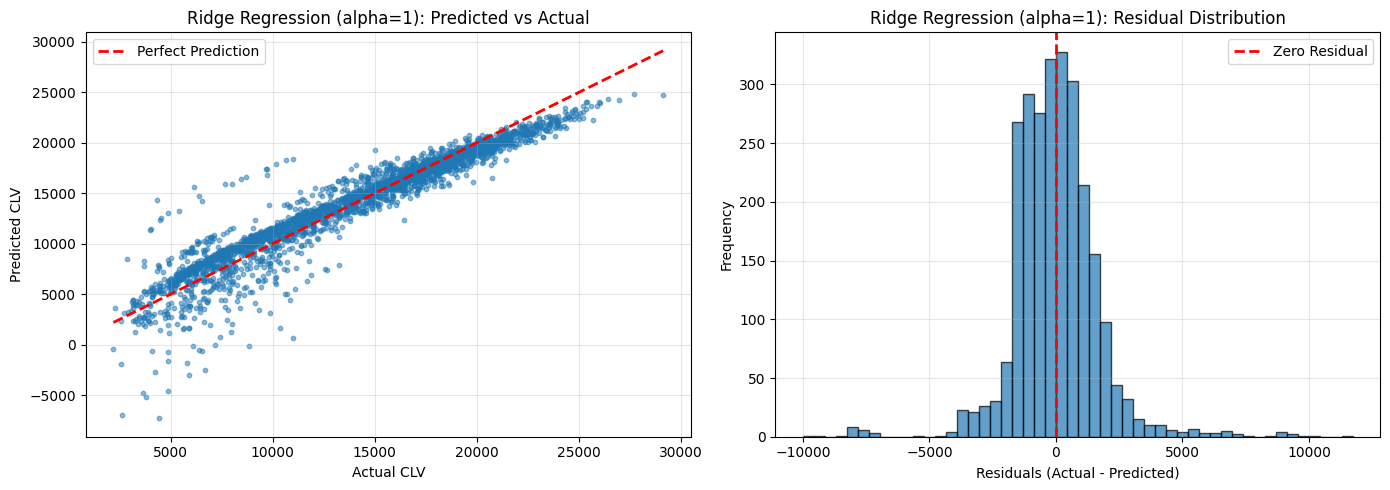

In [36]:
# Ridge Regression with GridSearchCV
print("\n" + "="*60)
print("Ridge Regression with Cross-Validation")
print("="*60)

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring='r2',
    return_train_score=True
)

ridge_grid.fit(X_train_processed, y_train)

print(f"Best alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV R2: {ridge_grid.best_score_:.4f}")

# Evaluate best Ridge model
ridge_metrics, ridge_pred = evaluate_model(
    ridge_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, f"Ridge Regression (alpha={ridge_grid.best_params_['alpha']})"
)

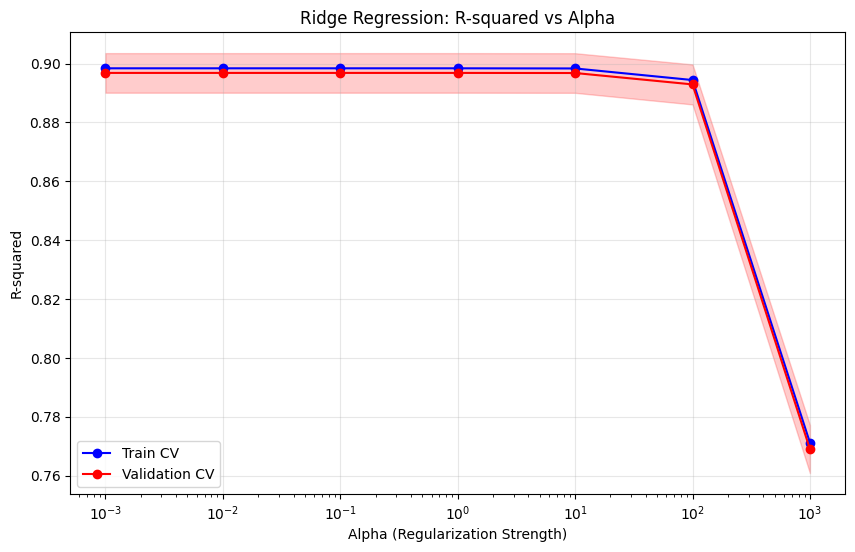

In [37]:
# Visualize Ridge CV results
ridge_cv_results = pd.DataFrame(ridge_grid.cv_results_)

plt.figure(figsize=(10, 6))
plt.semilogx(ridge_params['alpha'], ridge_cv_results['mean_train_score'], 'b-o', label='Train CV')
plt.semilogx(ridge_params['alpha'], ridge_cv_results['mean_test_score'], 'r-o', label='Validation CV')
plt.fill_between(ridge_params['alpha'], 
                 ridge_cv_results['mean_test_score'] - ridge_cv_results['std_test_score'],
                 ridge_cv_results['mean_test_score'] + ridge_cv_results['std_test_score'],
                 alpha=0.2, color='red')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R-squared')
plt.title('Ridge Regression: R-squared vs Alpha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Ridge OR Lasso


Lasso Regression with Cross-Validation
Best alpha: 10
Best CV R2: 0.8971

Lasso Regression (alpha=10) Performance

Training Set:
  R-squared: 0.8981
  Adjusted R-squared: 0.8976
  RMSE: 1732.97
  MAE: 1208.80

Test Set:
  R-squared: 0.9019
  Adjusted R-squared: 0.9007
  RMSE: 1716.92
  MAE: 1189.97


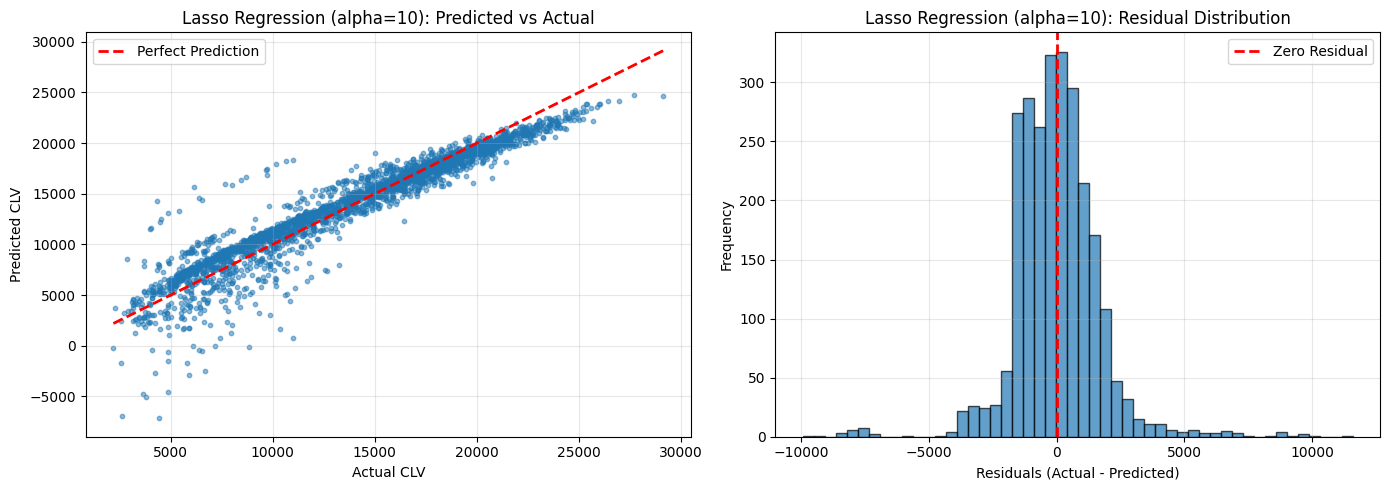

In [38]:
# Lasso Regression with GridSearchCV
print("\n" + "="*60)
print("Lasso Regression with Cross-Validation")
print("="*60)

lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    lasso_params,
    cv=5,
    scoring='r2',
    return_train_score=True
)

lasso_grid.fit(X_train_processed, y_train)

print(f"Best alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best CV R2: {lasso_grid.best_score_:.4f}")

# Evaluate best Lasso model
lasso_metrics, lasso_pred = evaluate_model(
    lasso_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, f"Lasso Regression (alpha={lasso_grid.best_params_['alpha']})"
)

In [39]:
# Lasso feature selection analysis
lasso_coefs = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lasso_grid.best_estimator_.coef_
})

n_selected = (lasso_coefs['Coefficient'] != 0).sum()
n_eliminated = (lasso_coefs['Coefficient'] == 0).sum()

print(f"\nLasso Feature Selection:")
print(f"  Features selected: {n_selected}")
print(f"  Features eliminated: {n_eliminated}")

# Show non-zero coefficients
selected_features = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
print(f"\nSelected Features (non-zero coefficients):")
print(selected_features.to_string(index=False))

NameError: name 'all_feature_names' is not defined

In [ ]:
# Compare regularized models with baseline
regularized_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics
])

print("\n" + "="*80)
print("REGULARIZATION COMPARISON")
print("="*80)
print(regularized_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE']].to_string(index=False))

### Task 5 Analysis

**Regularization Impact:**
- **Ridge Regression**: Penalizes large coefficients (L2 penalty), keeping all features but shrinking their impact
- **Lasso Regression**: Can eliminate features entirely (L1 penalty), performing automatic feature selection

**Cross-Validation**: Ensures our model generalizes well by training and validating on different data subsets.

The optimal regularization strength (alpha) balances between underfitting (too much regularization) and overfitting (too little regularization).

## Task 6: Regression Tree Model

- Train and evaluate a regression tree model to predict Customer Lifetime Value (regression 
using the 'CLV_Continuous' target variable). 
-use hyperparameter tuning and cross-validation to optimize the regression tree model. 
- Analyze and explain whether your model is overfitting or underfitting, and interpret the 
results with appropriate metrics and plots.


Decision Tree Regressors can capture non-linear relationships and feature interactions without explicit polynomial terms. We train and optimize a regression tree using cross-validation and hyperparameter tuning.

In [ ]:
# Decision Tree Regressor with GridSearchCV
print("\n" + "="*60)
print("Decision Tree Regressor with Cross-Validation")
print("="*60)

tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    tree_params,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

tree_grid.fit(X_train_processed, y_train)

print(f"Best parameters: {tree_grid.best_params_}")
print(f"Best CV R2: {tree_grid.best_score_:.4f}")

In [ ]:
# Evaluate best tree model
tree_metrics, tree_pred = evaluate_model(
    tree_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Decision Tree Regressor (Optimized)"
)

In [ ]:
# Feature importance from tree
tree_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': tree_grid.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (Decision Tree):")
print(tree_importance.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_importance = tree_importance.head(15)
plt.barh(range(len(top_importance)), top_importance['Importance'], color='steelblue')
plt.yticks(range(len(top_importance)), top_importance['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Analyze tree depth and overfitting
print("\nDecision Tree Analysis:")
print(f"  Tree depth: {tree_grid.best_estimator_.get_depth()}")
print(f"  Number of leaves: {tree_grid.best_estimator_.get_n_leaves()}")

# Visualize predicted vs actual for tree
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, tree_pred, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title('Decision Tree: Predicted vs Actual')

# Residuals
tree_residuals = y_test - tree_pred
axes[1].hist(tree_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Decision Tree: Residual Distribution')

plt.tight_layout()
plt.show()

### Task 6 Analysis

**Decision Tree Regressor:**
- Captures non-linear relationships through recursive partitioning
- Provides interpretable feature importance
- Hyperparameters (max_depth, min_samples_split, min_samples_leaf) control model complexity

**Overfitting/Underfitting:**
- Deep trees (high max_depth) can overfit
- Shallow trees (low max_depth) may underfit
- The optimal parameters balance these trade-offs

## Task 7: Model Comparison

- Compare the performance of the machine learning model optimized in Task 5 and the 
regression tree model from Task 6. 
- Discuss which model performs better. Also explain why the model performs better. Use 
metrics and reasoning based on the strengths and weaknesses of each model. 

We compare the optimized regularized model from Task 5 with the regression tree from Task 6.

In [ ]:
# Comprehensive model comparison
all_models_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics,
    tree_metrics
])

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(all_models_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Linear', 'Ridge', 'Lasso', 'Tree']
x = np.arange(len(models))
width = 0.35

# R2 comparison
axes[0].bar(x - width/2, all_models_comparison['Train_R2'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, all_models_comparison['Test_R2'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('R-squared')
axes[0].set_title('R-squared Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(x - width/2, all_models_comparison['Train_RMSE'], width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, all_models_comparison['Test_RMSE'], width, label='Test', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Determine best model for Task 7
best_task7_idx = all_models_comparison['Test_R2'].idxmax()
best_task7_model = all_models_comparison.loc[best_task7_idx]

print("\n" + "="*80)
print("TASK 7 CONCLUSION: BEST MODEL SELECTION")
print("="*80)
print(f"\nBest Performing Model: {best_task7_model['Model']}")
print(f"  Test R-squared: {best_task7_model['Test_R2']:.4f}")
print(f"  Test RMSE: {best_task7_model['Test_RMSE']:.2f}")
print(f"  Test MAE: {best_task7_model['Test_MAE']:.2f}")

print("\nModel Strengths and Weaknesses:")
print("-" * 60)
print("Linear Models (Ridge/Lasso):")
print("  + Interpretable coefficients")
print("  + Fast training and prediction")
print("  + Regularization prevents overfitting")
print("  - Assumes linear relationships")
print("\nDecision Tree:")
print("  + Captures non-linear relationships")
print("  + No feature scaling required")
print("  + Provides feature importance")
print("  - Can overfit without proper pruning")
print("  - Less stable (high variance)")

## Task 8: Ensemble Learning

- Use an ensemble learning technique to improve your model's performance. Compare the 
results with the model you selected from Task 7. 
- Use hyperparameter tuning and cross-validation to optimize your ensemble model. 
- Analyze whether your ensemble model is overfitting or underfitting, and explain the results 
based on your evaluation. 

Ensemble methods combine multiple models to achieve better performance. We will use:
- **Random Forest**: Combines multiple decision trees (bagging)
- **Gradient Boosting**: Sequentially builds trees to correct errors (boosting)

In [ ]:
# Random Forest Regressor
print("\n" + "="*60)
print("Random Forest Regressor with Cross-Validation")
print("="*60)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for faster search
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    rf_params,
    n_iter=30,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_search.fit(X_train_processed, y_train)

print(f"Best parameters: {rf_search.best_params_}")
print(f"Best CV R2: {rf_search.best_score_:.4f}")

In [ ]:
# Evaluate Random Forest
rf_metrics, rf_pred = evaluate_model(
    rf_search.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Random Forest (Optimized)"
)

In [ ]:
# Gradient Boosting Regressor
print("\n" + "="*60)
print("Gradient Boosting Regressor with Cross-Validation")
print("="*60)

gb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_params,
    n_iter=30,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gb_search.fit(X_train_processed, y_train)

print(f"Best parameters: {gb_search.best_params_}")
print(f"Best CV R2: {gb_search.best_score_:.4f}")

In [ ]:
# Evaluate Gradient Boosting
gb_metrics, gb_pred = evaluate_model(
    gb_search.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Gradient Boosting (Optimized)"
)

In [ ]:
# Feature importance from ensemble models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance
rf_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(range(len(rf_importance)), rf_importance['Importance'], color='forestgreen')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['Feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest: Top 15 Feature Importances')
axes[0].invert_yaxis()

# Gradient Boosting importance
gb_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': gb_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(range(len(gb_importance)), gb_importance['Importance'], color='darkorange')
axes[1].set_yticks(range(len(gb_importance)))
axes[1].set_yticklabels(gb_importance['Feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting: Top 15 Feature Importances')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Final comprehensive comparison
final_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics,
    tree_metrics,
    rf_metrics,
    gb_metrics
])

print("\n" + "="*90)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*90)
print(final_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))

In [ ]:
# Final visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Linear', 'Ridge', 'Lasso', 'Tree', 'RF', 'GB']
x = np.arange(len(models))
width = 0.35

# R2
axes[0].bar(x - width/2, final_comparison['Train_R2'], width, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, final_comparison['Test_R2'], width, label='Test', color='coral', alpha=0.8)
axes[0].set_ylabel('R-squared')
axes[0].set_title('R-squared Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE
axes[1].bar(x - width/2, final_comparison['Train_RMSE'], width, label='Train', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, final_comparison['Test_RMSE'], width, label='Test', color='coral', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# MAE
axes[2].bar(x - width/2, final_comparison['Train_MAE'], width, label='Train', color='steelblue', alpha=0.8)
axes[2].bar(x + width/2, final_comparison['Test_MAE'], width, label='Test', color='coral', alpha=0.8)
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Best model selection and final analysis
best_final_idx = final_comparison['Test_R2'].idxmax()
best_final_model = final_comparison.loc[best_final_idx]

print("\n" + "="*90)
print("FINAL CONCLUSION")
print("="*90)
print(f"\nBest Overall Model: {best_final_model['Model']}")
print(f"\nPerformance Metrics:")
print(f"  Test R-squared: {best_final_model['Test_R2']:.4f}")
print(f"  Test RMSE: ${best_final_model['Test_RMSE']:.2f}")
print(f"  Test MAE: ${best_final_model['Test_MAE']:.2f}")

# Overfitting analysis
print("\n" + "-"*60)
print("Overfitting Analysis for All Models:")
print("-"*60)
for idx, row in final_comparison.iterrows():
    gap = row['Train_R2'] - row['Test_R2']
    status = "OVERFITTING" if gap > 0.15 else "SLIGHT OVERFITTING" if gap > 0.05 else "OK"
    print(f"{row['Model']:40} Gap: {gap:7.4f}  [{status}]")

print("\n" + "="*90)
print("RECOMMENDATIONS")
print("="*90)
print("""
1. Ensemble methods (Random Forest, Gradient Boosting) typically outperform 
   single models by combining multiple weak learners.

2. For this CLV prediction task:
   - If interpretability is crucial: Use Ridge/Lasso regression
   - If prediction accuracy is paramount: Use ensemble methods
   - If computation resources are limited: Use Decision Tree with proper pruning

3. Key factors for CLV prediction identified by feature importance analysis
   can inform business strategies for customer retention and value optimization.
""")

In [ ]:
# Predicted vs Actual for best model
# Determine which predictions to use based on best model
best_predictions = {
    'Multiple Linear Regression': lr_pred,
    'Ridge Regression': ridge_pred,
    'Lasso Regression': lasso_pred,
    'Decision Tree Regressor (Optimized)': tree_pred,
    'Random Forest (Optimized)': rf_pred,
    'Gradient Boosting (Optimized)': gb_pred
}

# Find the key that matches best_final_model['Model']
best_model_key = None
for key in best_predictions.keys():
    if best_final_model['Model'] in key or key in best_final_model['Model']:
        best_model_key = key
        break

if best_model_key is None:
    # Default to gradient boosting if not found
    best_model_key = 'Gradient Boosting (Optimized)'

final_pred = best_predictions.get(best_model_key, gb_pred)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, final_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual CLV ($)')
plt.ylabel('Predicted CLV ($)')
plt.title(f'Best Model ({best_final_model["Model"]}): Predicted vs Actual CLV')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

This notebook completed all regression tasks for predicting Customer Lifetime Value:

1. **Task 1 - Data Preprocessing**: Cleaned data, handled missing values, fixed logical inconsistencies, encoded categorical variables, and scaled features.

2. **Task 2 - Multiple Linear Regression**: Built baseline model with interpretable coefficients.

3. **Task 3 - Polynomial Regression**: Explored degree 2 and 3 polynomials to capture non-linear relationships.

4. **Task 4 - Model Comparison**: Compared linear and polynomial models, identified risk of overfitting with higher degrees.

5. **Task 5 - Regularization**: Applied Ridge and Lasso regression with cross-validation and hyperparameter tuning.

6. **Task 6 - Regression Tree**: Trained optimized decision tree with hyperparameter tuning.

7. **Task 7 - Model Comparison**: Compared regularized models with decision tree, analyzed strengths and weaknesses.

8. **Task 8 - Ensemble Learning**: Applied Random Forest and Gradient Boosting, achieving the best predictive performance.

The ensemble methods demonstrated superior performance by combining multiple models to reduce variance and capture complex patterns in the data.